### Library and Data Import

In [22]:
# Library import
from datetime import datetime
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.plot import plot_plotly
rcParams['figure.figsize'] = 10, 6

In [23]:
# Data import
df = pd.read_csv('Dataset/transactionbydate.csv', sep = ',')
df = df[['Total_Qty', 'Date']]
df = df.rename(columns={'Total_Qty':'value'})
df = df.set_index('Date')
df.head()

,value
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67


### Data Overview and Preparation

In [24]:
# Data Overview
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
value,365.0,50.126027,16.704461,15.0,38.0,49.0,59.0,119.0


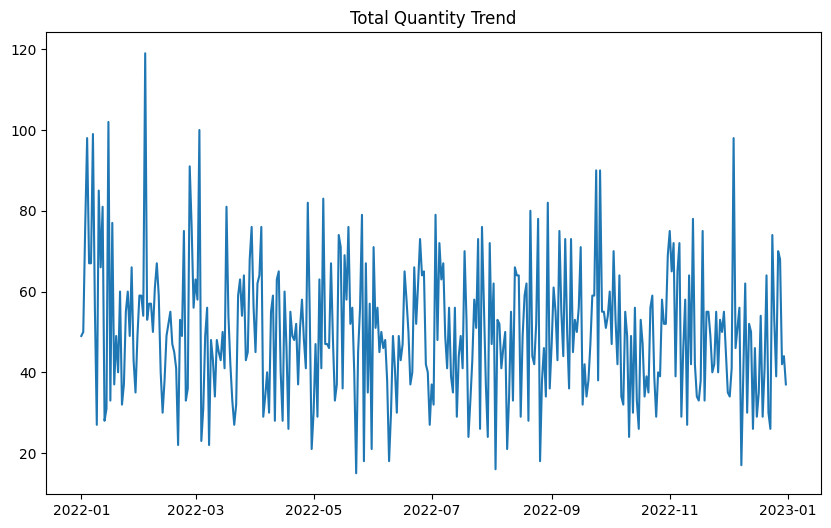

In [25]:
df.index = pd.to_datetime(df.index)
plt.plot(df.index, df['value'])
plt.title('Total Quantity Trend')
plt.show()

In [26]:
#Perform Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['value'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -19.018783
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


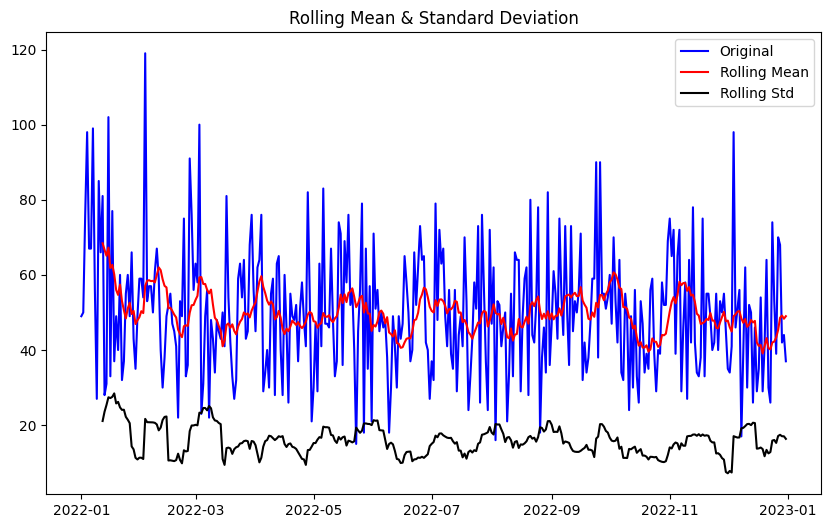

In [27]:
#Determine rolling statistics
movingAverage = df.rolling(window=12).mean()
movingSTD = df.rolling(window=12).std()
    
#Plot rolling statistics
orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
std = plt.plot(movingSTD, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

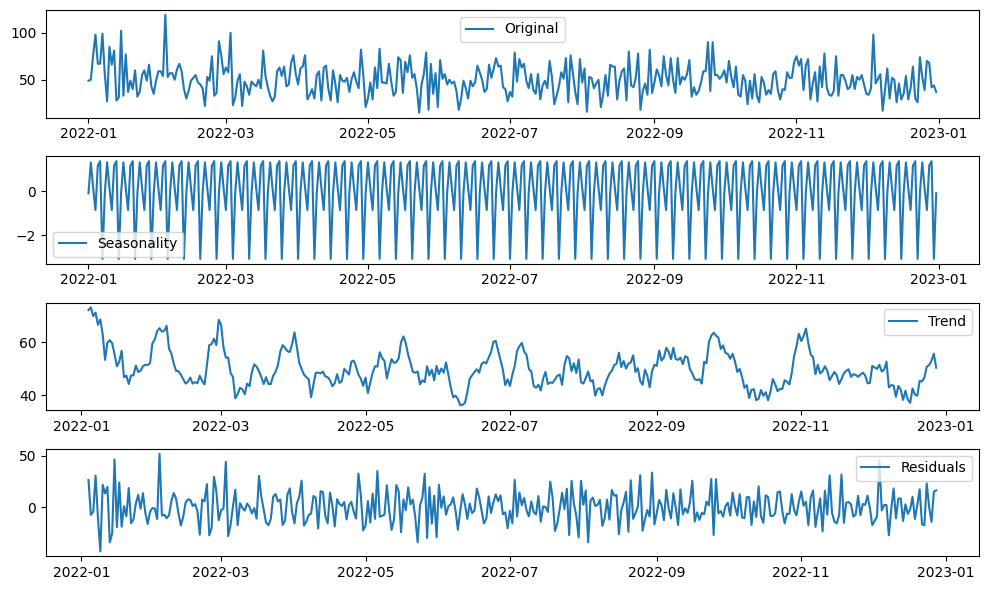

In [28]:
decomposition = seasonal_decompose(df) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

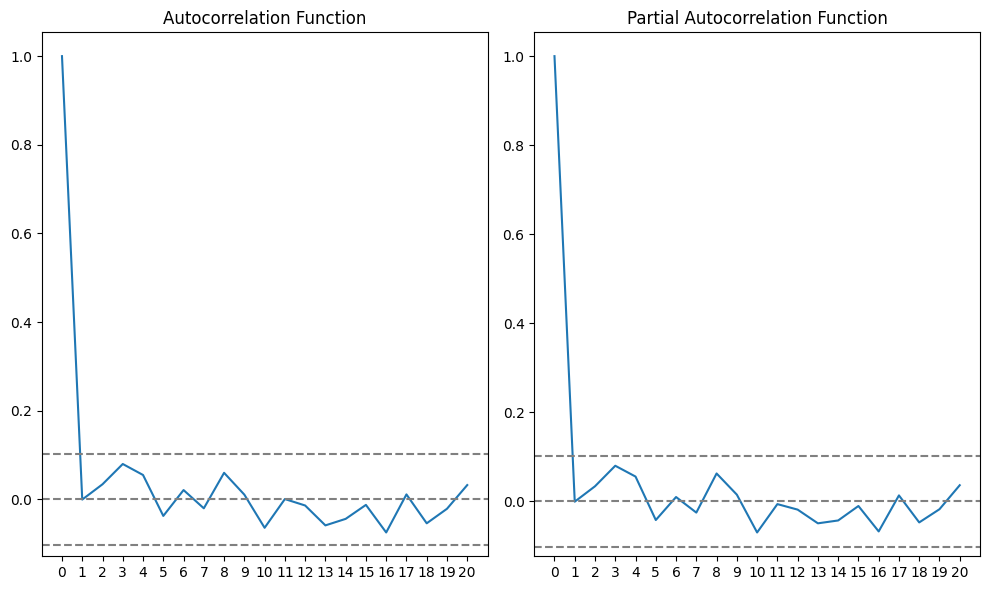

In [29]:
#ACF & PACF plots

lag_acf = acf(df, nlags=20)
lag_pacf = pacf(df, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.xticks(range(0, len(lag_acf)))     
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')     

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.xticks(range(0, len(lag_pacf)))
plt.axhline(y=-1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()  

In [30]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

train_data = df[1:round(len(df)*0.9)]
test_data = df[round(len(df)*0.9):]

p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 2)

best_model = None
best_mse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            warnings.filterwarnings("ignore")
            try:
                model = ARIMA(train_data.value, order=order).fit()
                predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
                error = mean_squared_error(test_data, predictions)

                if error < best_mse:
                    best_mse = error
                    best_model = model

            except:
                continue

print("\nBest ARIMA Model:")
print(best_model.summary())


Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  327
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -1399.293
Date:                Wed, 09 Aug 2023   AIC                           2812.587
Time:                        13:26:41   BIC                           2839.095
Sample:                    01-02-2022   HQIC                          2823.165
                         - 11-24-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8815      0.054    -16.308      0.000      -0.987      -0.776
ar.L2         -0.7046      0.076     -9.215      0.000      -0.855      -0.555
ar.L3         -0.5234      0.086 

In [31]:
model = ARIMA(train_data.value, order=(6,1,0)).fit()
predictions_arima = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
error = mean_squared_error(test_data, predictions_arima)
rmse = np.sqrt(error)
r2 = r2_score(test_data, np.array(predictions_arima))
print('MSE : ', error)
print('RMSE : ', rmse)
print('R2 Score : ', r2)

MSE :  242.97019047808902
RMSE :  15.58750109793385
R2 Score :  0.0058395876486824205


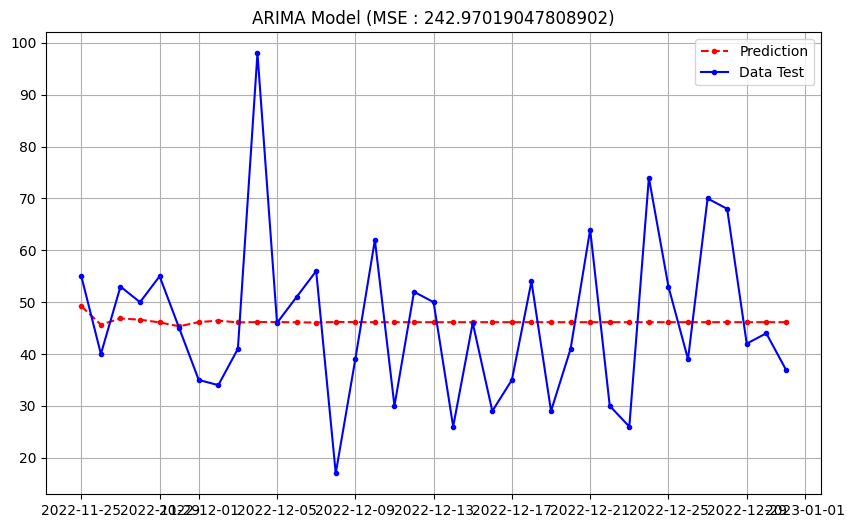

In [34]:
plt.figure(figsize = (10,6))
plt.grid(True)

plt.plot(predictions_arima.index, predictions_arima, color = 'red', marker = '.', linestyle = 'dashed', label = 'Prediction')
plt.plot(test_data.index, test_data, color = 'blue', marker = '.', label = 'Data Test')

plt.title('ARIMA Model (MSE : '  + error.astype(str) + ')')
plt.legend()
plt.show()

In [35]:
p_values = range(0, 15)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)

from itertools import product
best_model = None
best_mse = float('inf')

for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, 7)

    warnings.filterwarnings("ignore")
    try:
        model = ARIMA(train_data.value, order=order, seasonal_order=seasonal_order).fit()
        predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
        error = mean_squared_error(test_data, predictions)

        if error < best_mse:
            best_mse = error
            best_model = model

    except:
        continue

print("\nBest ARIMA Model:")
print(best_model.summary())



Best ARIMA Model:
                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  327
Model:             ARIMA(13, 0, 0)x(0, 0, [1], 7)   Log Likelihood               -1377.596
Date:                            Wed, 09 Aug 2023   AIC                           2787.192
Time:                                    13:37:04   BIC                           2847.831
Sample:                                01-02-2022   HQIC                          2811.388
                                     - 11-24-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.4753      1.197     42.164      0.000      48.129      52.822
ar.L1          0

In [36]:
model_tuning = ARIMA(train_data.value, order=(13, 0, 0), seasonal_order=(0, 0, 1, 7)).fit()
predictions_tuning = model_tuning.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
error_tuning = mean_squared_error(test_data, predictions_tuning)
rmse_tuning = np.sqrt(error_tuning)
r2_tuning = r2_score(test_data, np.array(predictions_tuning))
print('MSE : ', error_tuning)
print('RMSE : ', rmse_tuning)
print('R2 Score : ', r2_tuning)

MSE :  239.73732063739737
RMSE :  15.483453123815675
R2 Score :  0.019067511648643176


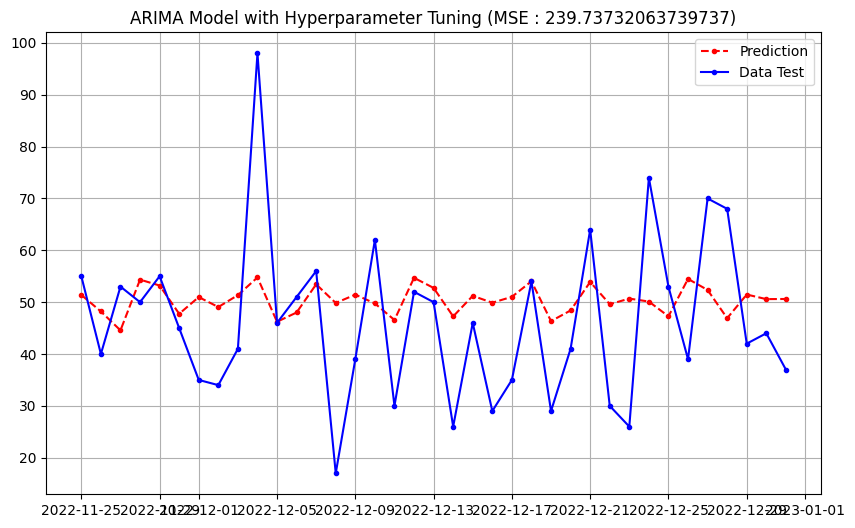

In [37]:
plt.figure(figsize = (10,6))
plt.grid(True)

plt.plot(predictions_tuning.index, predictions_tuning, color = 'red', marker = '.', linestyle = 'dashed', label = 'Prediction')
plt.plot(test_data.index, test_data, color = 'blue', marker = '.', label = 'Data Test')

plt.title('ARIMA Model with Hyperparameter Tuning (MSE : '  + error_tuning.astype(str) + ')')
plt.legend()
plt.show()

In [39]:
baseline_model = Prophet(changepoint_prior_scale = 0.1, seasonality_prior_scale = 0.0001, seasonality_mode = 'multiplicative')
train_data_prop = train_data.copy().reset_index().rename(columns = {'Date':'ds', 'value':'y'})
baseline_model.fit(train_data_prop)
future = baseline_model.make_future_dataframe(periods=len(test_data))
forecast = baseline_model.predict(future)
forecast_prophet = forecast.iloc[len(train_data_prop):]
predictions_prophet = forecast_prophet['yhat']
error_prophet = mean_squared_error(test_data, predictions_prophet)
rmse_prophet = np.sqrt(error_prophet)
r2_prophet = r2_score(test_data, predictions_prophet)
print('MSE : ', error_prophet)
print('RMSE : ', rmse_prophet)
print('R2 Score : ', r2_prophet)

13:38:24 - cmdstanpy - INFO - Chain [1] start processing
13:38:25 - cmdstanpy - INFO - Chain [1] done processing


MSE :  248.5481509149526
RMSE :  15.765409950741928
R2 Score :  -0.016983736632703916


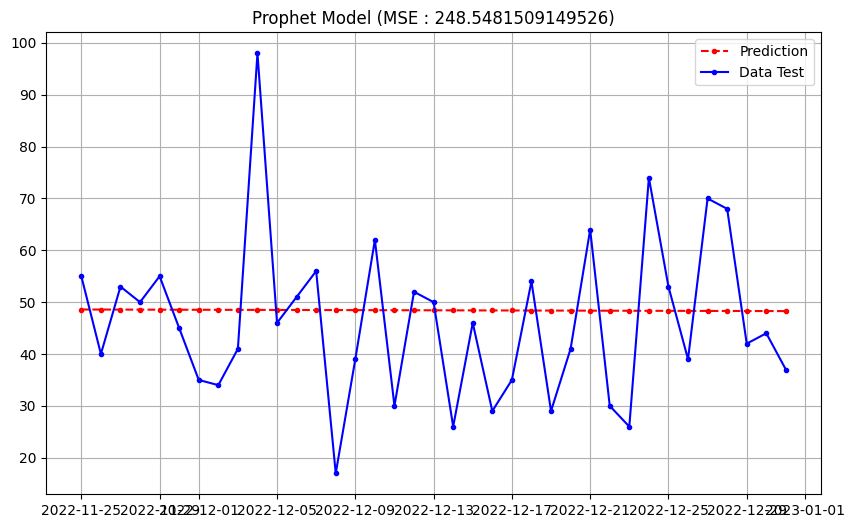

In [40]:
plt.figure(figsize = (10,6))
plt.grid(True)

plt.plot(test_data.index, predictions_prophet, color = 'red', marker = '.', linestyle = 'dashed', label = 'Prediction')
plt.plot(test_data.index, test_data, color = 'blue', marker = '.', label = 'Data Test')

plt.title('Prophet Model (MSE : '  + error_prophet.astype(str) + ')')
plt.legend()
plt.show()

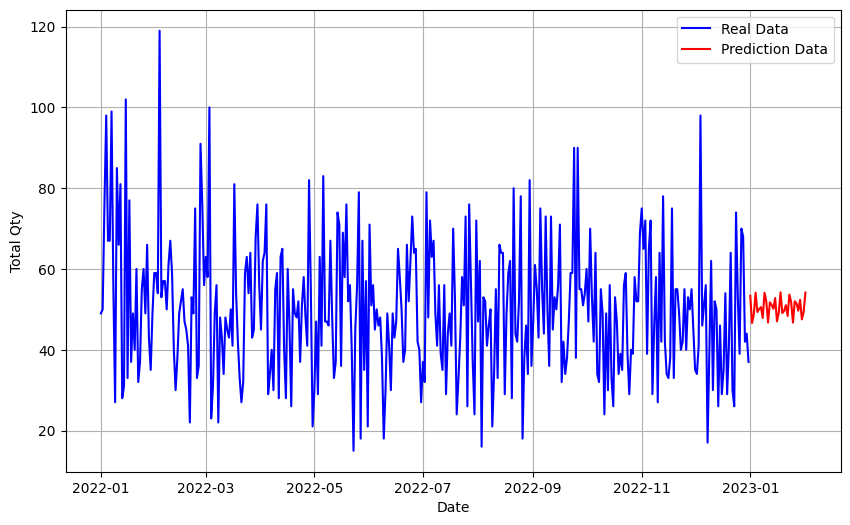

In [42]:
# Plot train and test data

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Total Qty')
plt.plot(df, 'blue', label = 'Real Data')
plt.plot(future_prediction, 'Red', label = 'Prediction Data')
plt.legend()

In [69]:
predictions_prophet = pd.DataFrame(predictions_prophet)
predictions_prophet = predictions_prophet.set_index(test_data.index)
result_total_qty = test_data.copy()
result_total_qty['Arima'] = predictions_arima
result_total_qty['Arima Tuning'] = predictions_tuning
result_total_qty['Prophet'] = predictions_prophet
result_total_qty.head()

,value,Arima,Arima Tuning,Prophet
Date,,,,
2022-11-25,55,49.226393,51.395575,48.584438
2022-11-26,40,45.656760,48.204269,48.575907
2022-11-27,53,46.860090,44.562216,48.567353
2022-11-28,50,46.616330,54.346816,48.558808
2022-11-29,55,46.102573,53.210161,48.550215


In [70]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=result_total_qty.index, y=result_total_qty['value'], mode='lines', name='Real Data', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=result_total_qty.index, y=result_total_qty['Arima'], mode='lines', name='Arima', line=dict(color='red')))
fig.add_trace(go.Scatter(x=result_total_qty.index, y=result_total_qty['Arima Tuning'], mode='lines', name='Arima With Tuning', line=dict(color='green')))
fig.add_trace(go.Scatter(x=result_total_qty.index, y=result_total_qty['Prophet'], mode='lines', name='Prophet', line=dict(color='orange')))

# Update the layout
fig.update_layout(title='Prediction with ARIMA',
                  xaxis_title='Date',
                  yaxis_title='Total Qty',
                  showlegend=True)

# Show the plot
fig.show()

In [90]:
future_prediction = model_tuning.predict(364,395)
future_prediction = pd.DataFrame(future_prediction)
prediction_totalqty = df[335:]
prediction_totalqty = pd.concat([prediction_totalqty, future_prediction])

In [97]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the real data trace
fig.add_trace(go.Scatter(x=prediction_totalqty.index, y=prediction_totalqty['value'], mode='lines', name='Real Data', line=dict(color='blue')))

# Add the prediction data trace
fig.add_trace(go.Scatter(x=prediction_totalqty.index, y=prediction_totalqty['predicted_mean'], mode='lines', name='Prediction Data', line=dict(color='red')))

# Update the layout
fig.update_layout(title='Prediction with ARIMA',
                  xaxis_title='Date',
                  yaxis_title='Total Qty',
                  showlegend=True)

# Show the plot
fig.show()